# 인터넷 경로로 Cats&Dogs Datasets 받아오기

In [2]:
# !wget --no-check-certificate \
# https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
# -O /content/drive/MyDrive/CNN_Study/Dogs_Cats/Datasets1/cats_and_dogs_filtered.zip 

import os
%matplotlib inline
# import zipfile

# local_zip = '/content/drive/MyDrive/CNN_Study/Dogs_Cats/Datasets_50MB/cats_and_dogs_filtered.zip'

# zip_ref = zipfile.ZipFile(local_zip, 'r')

# zip_ref.extractall('/content/drive/MyDrive/CNN_Study/Dogs_Cats/Datasets_50MB/')
# zip_ref.close()

# 경로 지정

In [3]:
base_dir = './cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# 파일 내의 이미지들을 리스트로 만들기

In [4]:
train_cats_list = os.listdir(train_cats_dir)
train_dogs_list = os.listdir(train_dogs_dir)

print(len(train_cats_list), len(train_dogs_list))

1000 1000


# 이미지 데이터 샘플 출력해보기

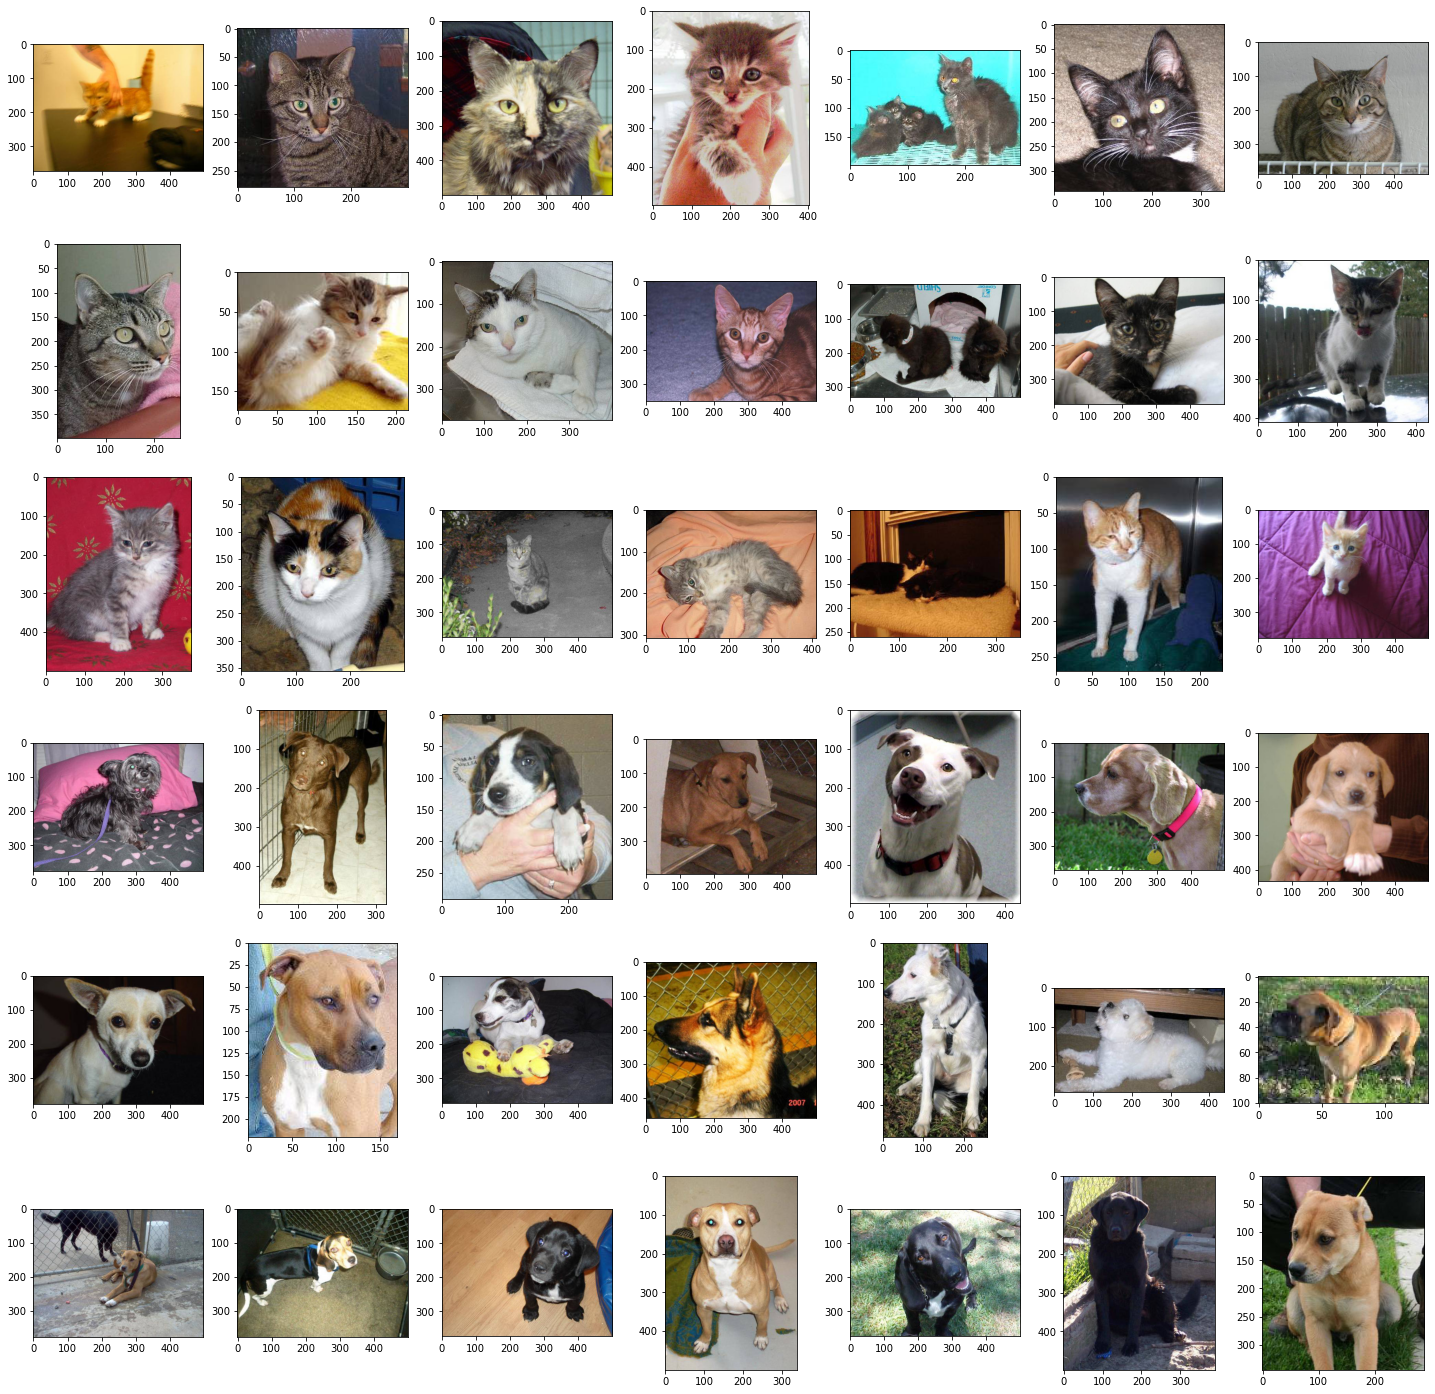

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 6, 7

figure = plt.figure(figsize=(25, 25))

sample_picture_cats_path = []
sample_picture_dogs_path = []

for filename in train_cats_list[:21]:
  sample_picture_cats_path.append( os.path.join(train_cats_dir, filename) )

for filename in train_dogs_list[:21]:
  sample_picture_dogs_path.append( os.path.join(train_dogs_dir, filename) )


for i, sampleimg_path in enumerate(sample_picture_cats_path+sample_picture_dogs_path):
  plt.subplot(nrows, ncols, i + 1)

  img = mpimg.imread(sampleimg_path)
  plt.imshow(img)

plt.show()

# Model 신경망 만들기

In [5]:
import tensorflow as tf


model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
                             tf.keras.layers.MaxPooling2D(2, 2), # (64, 64, 16)
                             tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

# Compile

In [9]:
from tensorflow.keras.optimizers import Adam

# 회귀문제 : MSE(mean_squared_error)
# 이진 분류 - Sigmoid
# 다중 클래스 분류 - Softmax
# 1) categorical_crossentropy(범주형 교차 엔트로피)
# 2) sparse_categorical_crossentropy 
#	: 범주형 교차 엔트로피와 동일하지만 이 경우 One-Hot encoding 상태일 필요없이 정수 encoding 상태에서 수행 가능
# loss(손실함수)
# Cross Entropy 란? : 
# metrics : ?
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['acc']
)

# ImageDataGenerator를 이용한 속성값 설정 및 Train/Test 만들기

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# ImageDataGenerator 속성
# rescale : 원래 이미지에 입력된 값만큼 이미지의 크기에 곱해서 조율 -> 값의 크기를 줄이기 위함으로 보임 [1./255]
# rotation_range : 지정된 각도 범위에서 임의로 원본 이미지를 회전 [0 ~ 100]
# width_shift_range / height_shift_range : 수평/수직 방향 내에서 임의로 원본 이미지를 좌우로 이동 [0 ~ 1]
# brightness_range : 이미지 밝기를 랜덤하게 주는 것 [0~1, 0~1]
# horizontal_flip : 수평방향으로 뒤집기 [True / False]
# validation_split : 주어진 데이터셋을 test와 training으로 나누는 비율 [0 ~ 1]
# shear_range : 이미지를 잘라내는 정도 [0 ~ 1]
# zoom_range : 확대 축소 정도 [0 ~ 1]
imageGenerator = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [.2, .2],
    horizontal_flip = True
)

# train_datagen = ImageDataGenerator( rescale = 1.0/255, rotation_range=0.2, width_shift_range=0.2, height_shift_range=0.2, 
#                                   brightness_range=[0.2, 0.2], horizontal_flip=True)
# validation_datagen = ImageDataGenerator( rescale = 1.0/255 ) 


# flow_from_directory method : 사용할 이미지 데이터를 폴더 형태의 데이터로 가져옴
# 속성
# 첫 인자 값 : 데이터의 경로
# - 설명 : '/content/drive/MyDrive/CNN_Study/Dogs_Cats/Datasets_50MB/cats_and_dogs_filtered/train'
# 위 경로에 있는 Cats 폴더와 Dogs 폴더 내의 이미지 데이터를 자동으로 labeling을 하게 됨
# class_mode : {'input', 'binary', 'categorical', 'sparse', None}
train_generator = imageGenerator.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    class_mode='binary',
                                                    batch_size=20)
validation_generator = imageGenerator.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              class_mode='binary',
                                                              batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 학습

In [11]:
# verbose : 0 = silent, 1 = progress bar, 2 = one line per epoch
# steps_per_epoch : epoch마다 데이터를 몇 번 볼 것인지 설정
# [train_generator.samples / epoch] = [주로 트레이닝 데이터의 수 / 배치 사이즈로 함]
# model이 ImageDataGenerator일 경우 model.fit_generator method를 이용해 학습시킴
# 그러나, fit method를 이용해서 학습이 됨
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 30,
                    steps_per_epoch = 100,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/30
100/100 - 16s - loss: 0.6807 - acc: 0.5780 - val_loss: 0.6826 - val_acc: 0.5720
Epoch 2/30
100/100 - 16s - loss: 0.6650 - acc: 0.5990 - val_loss: 0.6683 - val_acc: 0.5930
Epoch 3/30
100/100 - 16s - loss: 0.6444 - acc: 0.6395 - val_loss: 0.6282 - val_acc: 0.6520
Epoch 4/30
100/100 - 17s - loss: 0.6378 - acc: 0.6395 - val_loss: 0.6402 - val_acc: 0.6440
Epoch 5/30
100/100 - 17s - loss: 0.6121 - acc: 0.6715 - val_loss: 0.6199 - val_acc: 0.6690
Epoch 6/30
100/100 - 17s - loss: 0.5963 - acc: 0.6880 - val_loss: 0.6242 - val_acc: 0.6470
Epoch 7/30
100/100 - 17s - loss: 0.6025 - acc: 0.6835 - val_loss: 0.6109 - val_acc: 0.6660
Epoch 8/30
100/100 - 17s - loss: 0.5917 - acc: 0.6955 - val_loss: 0.6072 - val_acc: 0.6610
Epoch 9/30
100/100 - 17s - loss: 0.5935 - acc: 0.6555 - val_loss: 0.5999 - val_acc: 0.6790
Epoch 10/30
100/100 - 17s - loss: 0.5828 - acc: 0.6940 - val_loss: 0.6300 - val_acc: 0.6530
Epoch 11/30
100/100 - 17s - loss: 0.5699 - acc: 0.6980 - val_loss: 0.5839 - val_acc: 0.69

# 학습 결과 시각화

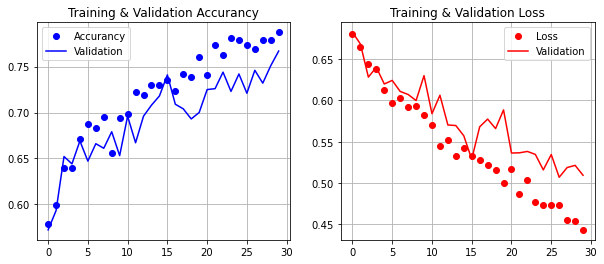

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epoch, acc, 'bo', label='Accurancy')
plt.plot(epoch, val_acc, 'b', label='Validation')
plt.title('Training & Validation Accurancy')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch, loss, 'ro', label='Loss')
plt.plot(epoch, val_loss, 'r', label='Validation')
plt.title('Training & Validation Loss')
plt.grid()
plt.legend()

plt.show()